In [53]:
#Hello

In [1]:
#Import Libraries
import pandas as pd
import os

In [5]:
# Path to data folder relative to the notebook
DATA_DIR = os.path.join("..", "data", "raw")

In [56]:
ace_violations = pd.read_csv(os.path.join(DATA_DIR, "ACE_violations.csv"))

In [57]:
ace_violations.head()

,Violation ID,Vehicle ID,First Occurrence,Last Occurrence,Violation Status,Violation Type,Bus Route ID,Violation Latitude,Violation Longitude,Stop ID,Stop Name,Bus Stop Latitude,Bus Stop Longitude,Violation Georeference,Bus Stop Georeference
0,489739752,6be26f24256f82d0efbf8da34f96c257d427aef7555f76...,08/20/2025 08:51:35 PM,08/20/2025 08:56:06 PM,EXEMPT - EMERGENCY VEHICLE,MOBILE BUS STOP,BX12+,40.860858,-73.889901,104015,EAST FORDHAM RD/3 AV,40.861137,-73.890431,POINT (-73.889901 40.860858),POINT (-73.890431 40.861137)
1,489738493,90ac673c1863016e6930cfa6e0e9fd5ffcb7e6a74473fd...,08/20/2025 07:24:30 PM,08/20/2025 07:30:28 PM,TECHNICAL ISSUE/OTHER,MOBILE BUS STOP,BX12+,40.861937,-73.891962,103999,EAST FORDHAM RD/WEBSTER AV,40.861596,-73.891066,POINT (-73.891962 40.861937),POINT (-73.891066 40.861596)
2,489737964,90ac673c1863016e6930cfa6e0e9fd5ffcb7e6a74473fd...,08/20/2025 06:56:14 PM,08/20/2025 07:05:29 PM,TECHNICAL ISSUE/OTHER,MOBILE BUS STOP,BX12+,40.862738,-73.902027,100796,WEST FORDHAM RD/UNIVERSITY AV,40.862703,-73.904256,POINT (-73.902027 40.862738),POINT (-73.904256 40.862703)
3,489737555,bc696033f16f49939e68f5fde21331602e130d954ec70a...,08/20/2025 06:52:43 PM,08/20/2025 06:56:49 PM,EXEMPT - BUS/PARATRANSIT,MOBILE BUS STOP,BX12+,40.861388,-73.890929,103999,EAST FORDHAM RD/WEBSTER AV,40.861596,-73.891066,POINT (-73.890929 40.861388),POINT (-73.891066 40.861596)
4,489736422,f39f90e1188b76c7b0b7675e2539e0a03c8f6ccc6b21d0...,08/20/2025 05:30:15 PM,08/20/2025 05:33:21 PM,TECHNICAL ISSUE/OTHER,MOBILE BUS STOP,BX12+,40.860971,-73.890124,104015,EAST FORDHAM RD/3 AV,40.861137,-73.890431,POINT (-73.890124 40.860971),POINT (-73.890431 40.861137)


In [58]:
# Number of rows and columns
#print(ace_violations.shape)

#print(ace_violations.info())

# Summary statistics for numeric columns
#print(ace_violations.describe())

# For object (string/categorical) columns
#print(ace_violations.describe(include="object"))

# Count missing values per column
#print(ace_violations.isna().sum())

# Most common violation statuses
#print(ace_violations["Violation Status"].value_counts())

# Most common violation types
#print(ace_violations["Violation Type"].value_counts())

# Bus routes with most violations
#print(ace_violations["Bus Route ID"].value_counts().head(10))


In [59]:
ace_violations["First Occurrence"] = pd.to_datetime(ace_violations["First Occurrence"])
ace_violations["Last Occurrence"] = pd.to_datetime(ace_violations["Last Occurrence"])

# Convert First Occurrence to datetime
ace_violations["First Occurrence"] = pd.to_datetime(ace_violations["First Occurrence"])

# Filter for dates starting from 2024-06-20
ace_violations = ace_violations[ace_violations["First Occurrence"] >= "2024-06-20"]

# Extract useful time parts
ace_violations["date"] = ace_violations["First Occurrence"].dt.date
ace_violations["quarter"] = ace_violations["First Occurrence"].dt.to_period("Q")  # e.g. 2024Q2, 2024Q3

# Count violations per day per quarter
violations_per_day = (
    ace_violations.groupby(["quarter", "date"])
    .size()
    .reset_index(name="violations")
)

# Sort results
violations_per_day = violations_per_day.sort_values(["quarter", "date"])

print(violations_per_day)


/var/folders/r2/62xph3kj5rj_w51slp5lpvyc0000gn/T/ipykernel_62526/410756338.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ace_violations["First Occurrence"] = pd.to_datetime(ace_violations["First Occurrence"])
/var/folders/r2/62xph3kj5rj_w51slp5lpvyc0000gn/T/ipykernel_62526/410756338.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ace_violations["Last Occurrence"] = pd.to_datetime(ace_violations["Last Occurrence"])


    quarter        date  violations
0    2024Q2  2024-06-20         299
1    2024Q2  2024-06-21         267
2    2024Q2  2024-06-22         240
3    2024Q2  2024-06-23          35
4    2024Q2  2024-06-24         267
..      ...         ...         ...
422  2025Q3  2025-08-16          25
423  2025Q3  2025-08-17          33
424  2025Q3  2025-08-18          36
425  2025Q3  2025-08-19          51
426  2025Q3  2025-08-20          27

[427 rows x 3 columns]


In [60]:
# Average violations per day (int) + number of days observed in each quarter
avg_violations_per_quarter = (
    violations_per_day.groupby("quarter")["violations"]
    .agg(avg_per_day=lambda x: int(round(x.mean())),   # average as int
         days_observed="count")                        # number of days with data
    .reset_index()
    .rename(columns={"avg_per_day": "avg_violations_per_day"})
)

#print(avg_violations_per_quarter)
# Drop the first quarter (2024Q2)
avg_violations_per_quarter = avg_violations_per_quarter[avg_violations_per_quarter["quarter"] != "2024Q2"]

print(avg_violations_per_quarter)

  quarter  avg_violations_per_day  days_observed
1  2024Q3                     309             92
2  2024Q4                     297             92
3  2025Q1                     230             90
4  2025Q2                     228             91
5  2025Q3                     157             51


In [31]:

# Get the absolute path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Construct the full path to the output file
output_path = os.path.join(project_root, "data", "processed", "violations_df.csv")

# Save the CSV
avg_violations_per_quarter.to_csv(output_path, index=False)


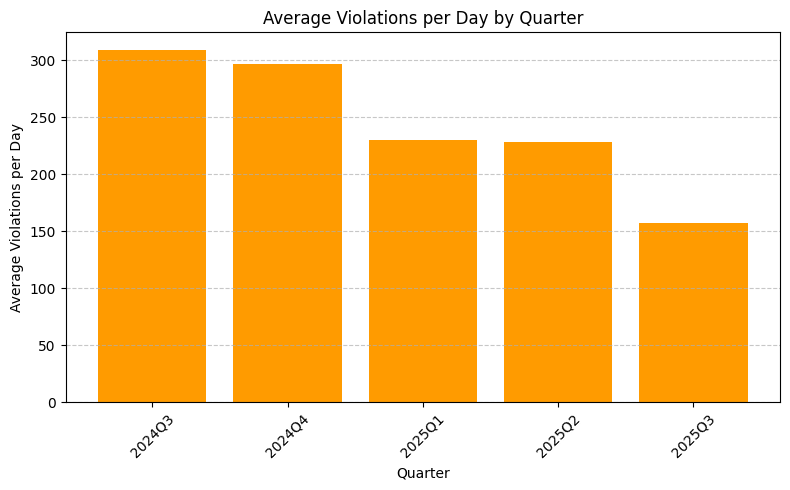

In [61]:
import matplotlib.pyplot as plt

# Example data
import pandas as pd
avg_violations_per_quarter = pd.DataFrame({
    "quarter": ["2024Q3", "2024Q4", "2025Q1", "2025Q2", "2025Q3"],
    "avg_violations_per_day": [309, 297, 230, 228, 157],
    "days_observed": [92, 92, 90, 91, 51]
})

# Plot
plt.figure(figsize=(8,5))
plt.bar(avg_violations_per_quarter["quarter"], avg_violations_per_quarter["avg_violations_per_day"], color="#FF9B00")
plt.xlabel("Quarter")
plt.ylabel("Average Violations per Day")
plt.title("Average Violations per Day by Quarter")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


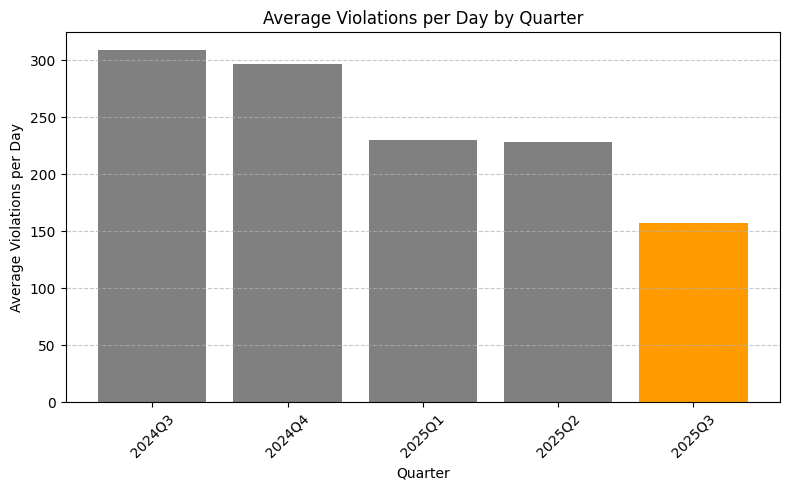

In [62]:
import matplotlib.pyplot as plt

# Example data
import pandas as pd
avg_violations_per_quarter = pd.DataFrame({
    "quarter": ["2024Q3", "2024Q4", "2025Q1", "2025Q2", "2025Q3"],
    "avg_violations_per_day": [309, 297, 230, 228, 157],
    "days_observed": [92, 92, 90, 91, 51]
})

# Set colors: gray for all except last quarter
colors = ["gray"] * (len(avg_violations_per_quarter) - 1) + ["#FF9B00"]

# Plot
plt.figure(figsize=(8,5))
plt.bar(avg_violations_per_quarter["quarter"], 
        avg_violations_per_quarter["avg_violations_per_day"], 
        color=colors)
plt.xlabel("Quarter")
plt.ylabel("Average Violations per Day")
plt.title("Average Violations per Day by Quarter")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
#Bus Speeds

In [ ]:
#data/raw/bus_speed_2020_2024.csv
#data/raw/bus_speed_2025.csv

In [4]:
# Path to data folder relative to the notebook
DATA_DIR = os.path.join("..", "data", "raw")

In [5]:
bus_speed_2020_2024 = pd.read_csv(os.path.join(DATA_DIR, "bus_speed_2020_2024.csv"))
bus_speed_2025 = pd.read_csv(os.path.join(DATA_DIR, "bus_speed_2025.csv"))

In [6]:
# Concatenate
bus_speed_all = pd.concat([bus_speed_2020_2024, bus_speed_2025], ignore_index=True)

print(bus_speed_all.shape)
print(bus_speed_all.head())

(266, 9)
        month borough  day_type trip_type route_id    period  total_mileage  \
0  2020-01-01   Bronx         1       SBS    BX12+  Off-Peak      33721.812   
1  2020-01-01   Bronx         1       SBS    BX12+      Peak      16727.904   
2  2020-01-01   Bronx         2       SBS    BX12+  Off-Peak      11895.368   
3  2020-01-01   Bronx         2       SBS    BX12+      Peak       5410.110   
4  2020-02-01   Bronx         1       SBS    BX12+  Off-Peak      30151.406   

   total_operating_time  average_speed  
0                  3532       9.546405  
1                  1930       8.666668  
2                  1187      10.019906  
3                   547       9.887283  
4                  3167       9.518541  


   quarter  avg_speed
0   2023Q1       9.63
1   2023Q2       9.34
2   2023Q3       9.36
3   2023Q4       9.28
4   2024Q1       9.57
5   2024Q2       9.28
6   2024Q3       9.38
7   2024Q4       9.30
8   2025Q1       9.72
9   2025Q2       9.30
10  2025Q3       9.39


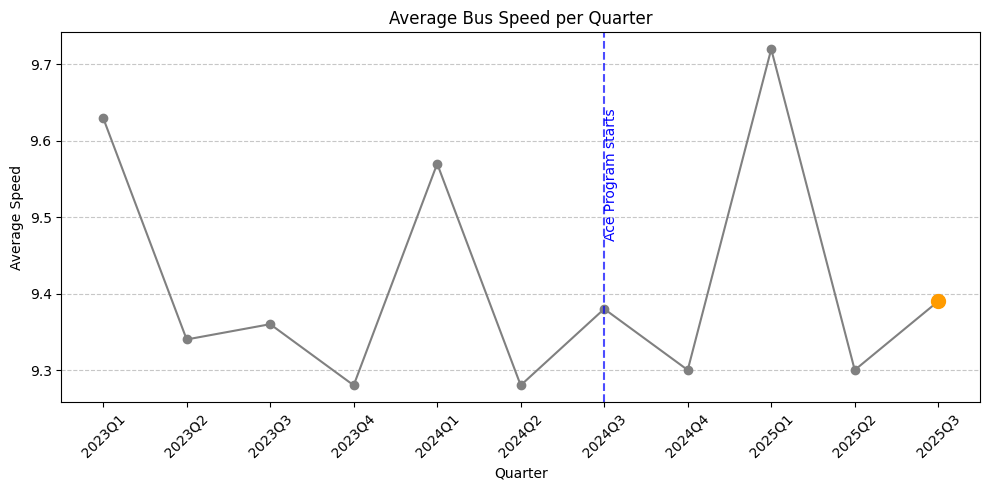

In [9]:
# Ensure month is datetime
bus_speed_all["month"] = pd.to_datetime(bus_speed_all["month"])

# Filter from 2023 onward
bus_speed_all = bus_speed_all[bus_speed_all["month"] >= "2023-01-01"]

# Add quarter column
bus_speed_all["quarter"] = bus_speed_all["month"].dt.to_period("Q")

# Compute average speed per quarter
avg_speed_per_quarter = (
    bus_speed_all.groupby("quarter")["average_speed"]
    .mean()
    .round(2)   # round to 2 decimals for readability
    .reset_index(name="avg_speed")
)

print(avg_speed_per_quarter)

import matplotlib.pyplot as plt
import pandas as pd

# Example data
avg_speed_per_quarter = pd.DataFrame({
    "quarter": ["2023Q1","2023Q2","2023Q3","2023Q4","2024Q1","2024Q2","2024Q3","2024Q4","2025Q1","2025Q2","2025Q3"],
    "avg_speed": [9.63,9.34,9.36,9.28,9.57,9.28,9.38,9.30,9.72,9.30,9.39]
})

# Create the plot
plt.figure(figsize=(10,5))

# Plot line
plt.plot(avg_speed_per_quarter["quarter"], avg_speed_per_quarter["avg_speed"], color="gray", marker='o')

# Highlight last quarter
plt.plot(avg_speed_per_quarter["quarter"].iloc[-1], 
         avg_speed_per_quarter["avg_speed"].iloc[-1], 
         marker='o', color="#FF9B00", markersize=10)

# Add vertical line at 2024Q3
plt.axvline(x="2024Q3", color='blue', linestyle='--', alpha=0.7)
plt.text("2024Q3", plt.ylim()[1]-0.1, "Ace Program starts", rotation=90, verticalalignment='top', color='blue')

# Labels and title
plt.xlabel("Quarter")
plt.ylabel("Average Speed")
plt.title("Average Bus Speed per Quarter")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()



In [38]:
from scipy import stats
import pandas as pd

# Ensure datetime
bus_speed_all["month"] = pd.to_datetime(bus_speed_all["month"])

# Split before vs after June 20, 2024
before = bus_speed_all[bus_speed_all["month"] < "2024-06-20"]["average_speed"]
after = bus_speed_all[bus_speed_all["month"] >= "2024-06-20"]["average_speed"]

print(f"Before period count: {len(before)}, mean={before.mean():.2f}")
print(f"After period count:  {len(after)}, mean={after.mean():.2f}")

# Welch's t-test
t_stat, p_value = stats.ttest_ind(before, after, equal_var=False, nan_policy="omit")

print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.4f}")


Before period count: 72, mean=9.41
After period count:  52, mean=9.42
T-statistic: -0.148, P-value: 0.8830


In [50]:
'''
What you have
Before period: 72 observations, average speed = 9.41
After period: 52 observations, average speed = 9.42
t-statistic = -0.148 (very close to 0 → means the two groups are almost identical)
p-value = 0.8830 (much larger than 0.05)
Interpretation
The means (9.41 vs 9.42) are basically the same — a difference of 0.01 mph, which is negligible.
The p-value (0.883) means there’s an 88% chance of seeing a difference this small (or smaller) just due to random variation, if the true means were equal.
Since p >> 0.05, you cannot reject the null hypothesis → there is no statistically significant difference in average speeds before and after 6/20/2024.
In plain language
The BX12+ bus did not statistically speed up or slow down after congestion pricing went into effect. Speeds are essentially the same.
'''


# Get the absolute path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Construct the full path to the output file
output_path = os.path.join(project_root, "data", "processed", "avg_speed_per_quarter.csv")

# Save the CSV
avg_speed_per_quarter.to_csv(output_path, index=False)


In [6]:
#Bus Wait Assessment
#Wait Assessment measures how evenly buses are spaced.
#Wait Assessment (WA) measures how evenly buses are spaced. It is defined as the percentage 
#of actual intervals between buses that are no more than three minutes over the scheduled 
#interval for the morning (7 a.m. to 9 a.m.) and afternoon (4 p.m. to 7 p.m.) peak periods 
#and no more than five minutes
#over the scheduled interval for the rest of the day (off-peak).

#data/raw/wait_assessment_2020_2024.csv
#data/raw/wait_assessment_2025.csv

In [7]:
wait_assessment_2020_2024 = pd.read_csv(os.path.join(DATA_DIR, "wait_assessment_2020_2024.csv"))
wait_assessment_2025 = pd.read_csv(os.path.join(DATA_DIR, "wait_assessment_2025.csv"))

In [8]:
# Concatenate
wait_assessment_all = pd.concat([wait_assessment_2020_2024, wait_assessment_2025], ignore_index=True)

print(wait_assessment_all.shape)
print(wait_assessment_all.head())

(268, 9)
        month borough  day_type trip_type route_id    period  \
0  2020-01-01   Bronx         1       SBS    BX12+  Off-Peak   
1  2020-01-01   Bronx         1       SBS    BX12+      Peak   
2  2020-01-01   Bronx         2       SBS    BX12+  Off-Peak   
3  2020-01-01   Bronx         2       SBS    BX12+      Peak   
4  2020-02-01   Bronx         1       SBS    BX12+  Off-Peak   

   number_of_trips_passing_wait  number_of_scheduled_trips  wait_assessment  
0                          5290                       6854         0.771812  
1                          2411                       3671         0.656769  
2                          1912                       2316         0.825561  
3                           842                       1074         0.783985  
4                          4724                       6118         0.772148  


In [9]:
# Ensure 'month' is datetime
wait_assessment_all['month'] = pd.to_datetime(wait_assessment_all['month'])

# Filter from 2023 onward
wait_assessment_all = wait_assessment_all[wait_assessment_all['month'] >= "2023-01-01"]

# Extract quarter
wait_assessment_all['quarter'] = wait_assessment_all['month'].dt.to_period('Q')

# Compute average wait assessment per quarter
avg_wait_per_quarter = (
    wait_assessment_all.groupby('quarter')['wait_assessment']
    .mean()
    .reset_index()
)

# Optional: convert to float rounded to 3 decimals
avg_wait_per_quarter['wait_assessment'] = avg_wait_per_quarter['wait_assessment'].round(3)

# Sort by quarter
avg_wait_per_quarter = avg_wait_per_quarter.sort_values('quarter')

print(avg_wait_per_quarter)


   quarter  wait_assessment
0   2023Q1            0.814
1   2023Q2            0.768
2   2023Q3            0.742
3   2023Q4            0.742
4   2024Q1            0.750
5   2024Q2            0.731
6   2024Q3            0.700
7   2024Q4            0.706
8   2025Q1            0.745
9   2025Q2            0.693
10  2025Q3            0.681


In [10]:
from scipy.stats import ttest_ind
import pandas as pd

# Ensure 'month' is datetime
wait_assessment_all['month'] = pd.to_datetime(wait_assessment_all['month'])

# Split before and after 6/20/2024
before = wait_assessment_all[wait_assessment_all['month'] < "2024-06-20"]['wait_assessment']
after = wait_assessment_all[wait_assessment_all['month'] >= "2024-06-20"]['wait_assessment']

# Perform two-sample t-test (assuming unequal variances)
t_stat, p_val = ttest_ind(before, after, equal_var=False)

# Summary statistics
print(f"Before period count: {len(before)}, mean={before.mean():.3f}")
print(f"After period count:  {len(after)}, mean={after.mean():.3f}")
print(f"T-statistic: {t_stat:.3f}, P-value: {p_val:.4f}")


Before period count: 72, mean=0.758
After period count:  52, mean=0.709
T-statistic: 4.441, P-value: 0.0000


In [11]:
'''
Perfect — here’s how to interpret that:
Before mean: 0.758
After mean: 0.709 → the average wait assessment decreased after 6/20/2024.
T-statistic: 4.441 → this is a fairly large value, indicating the difference between 
before and after is many standard errors apart.
P-value: 0.0000 → essentially 0, meaning the change is highly statistically significant.
Conclusion: The wait assessment metric has significantly decreased after 6/20/2024. 
This suggests that the buses may be arriving closer to schedule or passengers are waiting less, 
depending on how the metric is defined.
'''
# Get the absolute path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Construct the full path to the output file
output_path = os.path.join(project_root, "data", "processed", "avg_wait_per_quarter.csv")

# Save the CSV
avg_wait_per_quarter.to_csv(output_path, index=False)


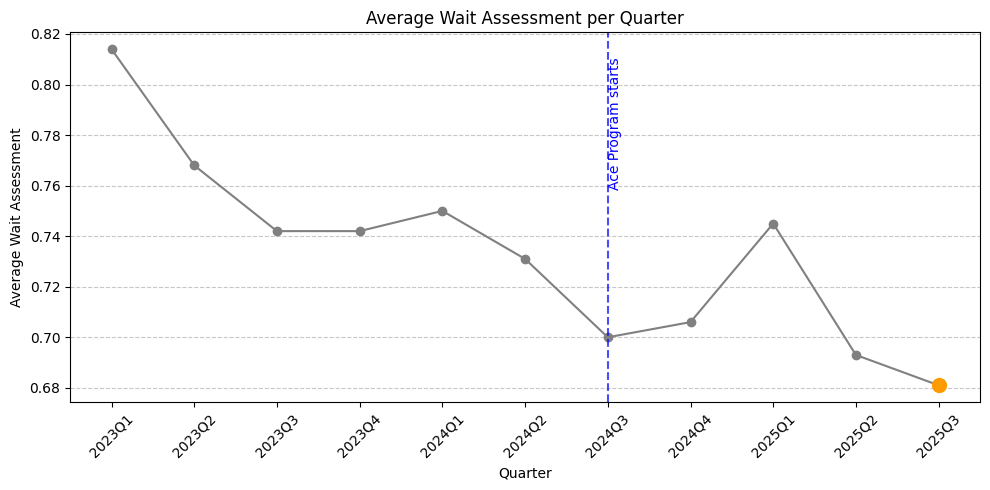

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Example data
avg_wait_per_quarter = pd.DataFrame({
    "quarter": ["2023Q1","2023Q2","2023Q3","2023Q4","2024Q1","2024Q2","2024Q3","2024Q4","2025Q1","2025Q2","2025Q3"],
    "wait_assessment": [0.814,0.768,0.742,0.742,0.750,0.731,0.700,0.706,0.745,0.693,0.681]
})

# Create the plot
plt.figure(figsize=(10,5))

# Plot line
plt.plot(avg_wait_per_quarter["quarter"], avg_wait_per_quarter["wait_assessment"], color="gray", marker='o')

# Highlight last quarter
plt.plot(avg_wait_per_quarter["quarter"].iloc[-1], 
         avg_wait_per_quarter["wait_assessment"].iloc[-1], 
         marker='o', color="#FF9B00", markersize=10)

# Add vertical line at 2024Q3
plt.axvline(x="2024Q3", color='blue', linestyle='--', alpha=0.7)
plt.text("2024Q3", plt.ylim()[1]-0.01, "Ace Program starts", rotation=90, verticalalignment='top', color='blue')

# Labels and title
plt.xlabel("Quarter")
plt.ylabel("Average Wait Assessment")
plt.title("Average Wait Assessment per Quarter")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [13]:
#Journey Focused Metrics
#data/raw/journey_metrics_2020_2024.csv
#data/raw/journey_metrics_2025.csv

'''
Additional Bus Stop Time (ABST) is the average added time that customers wait at a stop for a
bus, compared with their scheduled wait time. The measure assumes customers arrive at the
bus stop uniformly, except for routes with longer headways, where customers arrive more
closely aligned to the schedule. ABST is sometimes referred to as Excess Wait Time.

Additional Travel Time (ATT) is the average additional time customers spend onboard the bus
compared to the schedule. ATT is sometimes referred to as Excess In-Vehicle Travel Time.

Customer Journey Time Performance (CJTP) measures the percentage of customers who
complete their journey (ABST + ATT) within five minutes of the scheduled time. CJTP is
sometimes referred to as Excess Journey Time.
'''

'\nAdditional Bus Stop Time (ABST) is the average added time that customers wait at a stop for a\nbus, compared with their scheduled wait time. The measure assumes customers arrive at the\nbus stop uniformly, except for routes with longer headways, where customers arrive more\nclosely aligned to the schedule. ABST is sometimes referred to as Excess Wait Time.\n\nAdditional Travel Time (ATT) is the average additional time customers spend onboard the bus\ncompared to the schedule. ATT is sometimes referred to as Excess In-Vehicle Travel Time.\n\nCustomer Journey Time Performance (CJTP) measures the percentage of customers who\ncomplete their journey (ABST + ATT) within five minutes of the scheduled time. CJTP is\nsometimes referred to as Excess Journey Time.\n'

In [17]:
journey_metrics_2020_2024 = pd.read_csv(os.path.join(DATA_DIR, "journey_metrics_2020_2024.csv"))
journey_metrics_2025 = pd.read_csv(os.path.join(DATA_DIR, "journey_metrics_2025.csv"))

In [18]:
# Concatenate
journey_metrics_all = pd.concat([journey_metrics_2020_2024, journey_metrics_2025], ignore_index=True)

print(journey_metrics_all.shape)
print(journey_metrics_all.head())

(124, 9)
        month borough trip_type route_id    period  number_of_customers  \
0  2020-01-01   Bronx       SBS    BX12+  Off-Peak            421052.97   
1  2020-01-01   Bronx       SBS    BX12+      Peak            294862.25   
2  2020-02-01   Bronx       SBS    BX12+  Off-Peak            359577.62   
3  2020-02-01   Bronx       SBS    BX12+      Peak            254945.81   
4  2020-03-01   Bronx       SBS    BX12+  Off-Peak            190429.47   

   additional_bus_stop_time  additional_travel_time  \
0                  1.647969                1.151022   
1                  1.747048                1.749989   
2                  1.588225                1.274502   
3                  1.789825                2.002485   
4                  1.768806                1.487573   

   customer_journey_time_performance  
0                           0.691432  
1                           0.646283  
2                           0.687080  
3                           0.627390  
4             

In [19]:
import pandas as pd

# Ensure month is datetime
journey_metrics_all["month"] = pd.to_datetime(journey_metrics_all["month"])

# Filter for 2023 onward
journey_metrics_all_2023 = journey_metrics_all[journey_metrics_all["month"] >= "2023-01-01"]

# Extract quarter
journey_metrics_all_2023["quarter"] = journey_metrics_all_2023["month"].dt.to_period("Q")

# Compute average metrics per quarter
quarterly_metrics = (
    journey_metrics_all_2023.groupby("quarter")[["additional_bus_stop_time", 
                                                  "additional_travel_time", 
                                                  "customer_journey_time_performance"]]
    .mean()
    .reset_index()
)

# Optional: round for readability
quarterly_metrics[["additional_bus_stop_time", 
                   "additional_travel_time", 
                   "customer_journey_time_performance"]] = quarterly_metrics[
    ["additional_bus_stop_time", "additional_travel_time", "customer_journey_time_performance"]].round(3)

print(quarterly_metrics)


   quarter  additional_bus_stop_time  additional_travel_time  \
0   2023Q1                     1.388                   1.479   
1   2023Q2                     1.790                   1.858   
2   2023Q3                     2.094                   1.464   
3   2023Q4                     2.762                   1.847   
4   2024Q1                     2.303                   1.535   
5   2024Q2                     2.418                   1.920   
6   2024Q3                     2.671                   1.417   
7   2024Q4                     2.881                   1.662   
8   2025Q1                     2.101                   1.047   
9   2025Q2                     2.754                   1.992   
10  2025Q3                     2.470                   1.029   

    customer_journey_time_performance  
0                               0.688  
1                               0.639  
2                               0.656  
3                               0.621  
4                              

/var/folders/r2/62xph3kj5rj_w51slp5lpvyc0000gn/T/ipykernel_63828/1616330503.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  journey_metrics_all_2023["quarter"] = journey_metrics_all_2023["month"].dt.to_period("Q")


In [20]:
# Original dataframe
df = quarterly_metrics  # or the dataframe you just printed

# Separate dataframes
additional_bus_stop_time_df = df[["quarter", "additional_bus_stop_time"]].copy()
additional_travel_time_df = df[["quarter", "additional_travel_time"]].copy()
customer_journey_time_performance_df = df[["quarter", "customer_journey_time_performance"]].copy()

# Optional: print to check
print(additional_bus_stop_time_df)
print(additional_travel_time_df)
print(customer_journey_time_performance_df)


   quarter  additional_bus_stop_time
0   2023Q1                     1.388
1   2023Q2                     1.790
2   2023Q3                     2.094
3   2023Q4                     2.762
4   2024Q1                     2.303
5   2024Q2                     2.418
6   2024Q3                     2.671
7   2024Q4                     2.881
8   2025Q1                     2.101
9   2025Q2                     2.754
10  2025Q3                     2.470
   quarter  additional_travel_time
0   2023Q1                   1.479
1   2023Q2                   1.858
2   2023Q3                   1.464
3   2023Q4                   1.847
4   2024Q1                   1.535
5   2024Q2                   1.920
6   2024Q3                   1.417
7   2024Q4                   1.662
8   2025Q1                   1.047
9   2025Q2                   1.992
10  2025Q3                   1.029
   quarter  customer_journey_time_performance
0   2023Q1                              0.688
1   2023Q2                              0.63

In [21]:
import pandas as pd
from scipy.stats import ttest_ind

# Convert month to datetime
journey_metrics_all['month'] = pd.to_datetime(journey_metrics_all['month'])

# Split into before and after 6/20/2024
before = journey_metrics_all[journey_metrics_all['month'] < "2024-06-20"]
after = journey_metrics_all[journey_metrics_all['month'] >= "2024-06-20"]

# Metrics to test
metrics = [
    "additional_bus_stop_time",
    "additional_travel_time",
    "customer_journey_time_performance"
]

# Run t-tests
for metric in metrics:
    t_stat, p_val = ttest_ind(before[metric], after[metric], equal_var=False)  # Welch's t-test
    print(f"{metric} -> Before count: {len(before)}, After count: {len(after)}")
    print(f"Before mean: {before[metric].mean():.3f}, After mean: {after[metric].mean():.3f}")
    print(f"T-statistic: {t_stat:.3f}, P-value: {p_val:.4f}\n")


additional_bus_stop_time -> Before count: 98, After count: 26
Before mean: 1.990, After mean: 2.591
T-statistic: -5.133, P-value: 0.0000

additional_travel_time -> Before count: 98, After count: 26
Before mean: 1.507, After mean: 1.491
T-statistic: 0.120, P-value: 0.9051

customer_journey_time_performance -> Before count: 98, After count: 26
Before mean: 0.660, After mean: 0.633
T-statistic: 2.196, P-value: 0.0338



In [22]:
'''
1. additional_bus_stop_time
Before mean: 1.990
After mean: 2.591
T-statistic: -5.133
P-value: 0.0000
Interpretation:
The mean additional bus stop time increased from ~1.99 to ~2.59 after 6/20/2024. 
The p-value is essentially 0, which is much less than 0.05. This means the increase 
is statistically significant. In practical terms, buses are spending more time at stops after 
this date.


2. additional_travel_time
Before mean: 1.507
After mean: 1.491
T-statistic: 0.120
P-value: 0.9051
Interpretation:
The mean additional travel time is nearly the same before and after (1.507 vs 1.491), 
and the p-value is very high (~0.91). This means there is no statistically significant 
change in additional travel time.

3. customer_journey_time_performance
Before mean: 0.660
After mean: 0.633
T-statistic: 2.196
P-value: 0.0338

Interpretation:
The mean customer journey time performance decreased from 0.660 to 0.633. The p-value (~0.034) is less than 0.05, indicating this decrease is statistically significant. In practice, the overall journey performance for customers worsened slightly after 6/20/2024.

Summary:
Significant increase: additional_bus_stop_time → buses spend more time at stops.
No change: additional_travel_time → travel time itself did not change.
Significant decrease: customer_journey_time_performance → customers’ journey performance slightly worsened.
'''

'\n1. additional_bus_stop_time\nBefore mean: 1.990\nAfter mean: 2.591\nT-statistic: -5.133\nP-value: 0.0000\nInterpretation:\nThe mean additional bus stop time increased from ~1.99 to ~2.59 after 6/20/2024. \nThe p-value is essentially 0, which is much less than 0.05. This means the increase \nis statistically significant. In practical terms, buses are spending more time at stops after \nthis date.\n\n\n2. additional_travel_time\nBefore mean: 1.507\nAfter mean: 1.491\nT-statistic: 0.120\nP-value: 0.9051\nInterpretation:\nThe mean additional travel time is nearly the same before and after (1.507 vs 1.491), \nand the p-value is very high (~0.91). This means there is no statistically significant \nchange in additional travel time.\n\n3. customer_journey_time_performance\nBefore mean: 0.660\nAfter mean: 0.633\nT-statistic: 2.196\nP-value: 0.0338\n\nInterpretation:\nThe mean customer journey time performance decreased from 0.660 to 0.633. The p-value (~0.034) is less than 0.05, indicating t

In [23]:
# Get the absolute path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Construct the full path to the output file
output_path = os.path.join(project_root, "data", "processed", "additional_bus_stop_time_df.csv")
# Save the CSV
additional_bus_stop_time_df.to_csv(output_path, index=False)

# Construct the full path to the output file
output_path = os.path.join(project_root, "data", "processed", "additional_travel_time_df.csv")
# Save the CSV
additional_travel_time_df.to_csv(output_path, index=False)

# Construct the full path to the output file
output_path = os.path.join(project_root, "data", "processed", "customer_journey_time_performance_df.csv")
# Save the CSV
customer_journey_time_performance_df.to_csv(output_path, index=False)



TypeError: float() argument must be a string or a real number, not 'Period'

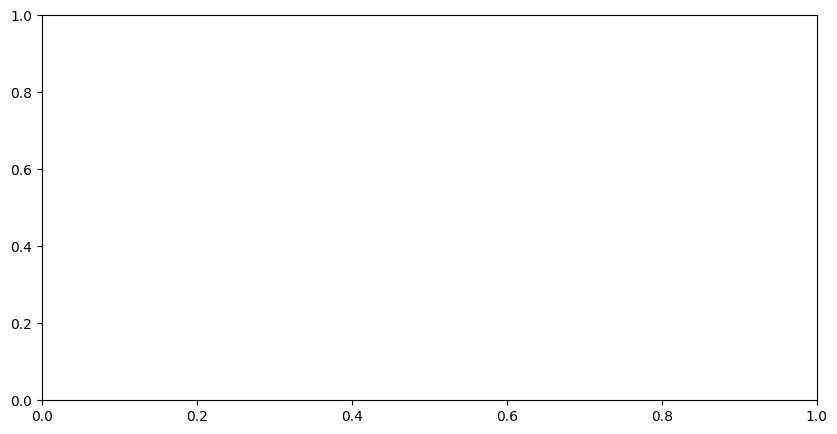

In [24]:
import matplotlib.pyplot as plt

# 1. Additional Bus Stop Time
plt.figure(figsize=(10,5))
plt.plot(additional_bus_stop_time_df["quarter"], additional_bus_stop_time_df["additional_bus_stop_time"], color="gray", marker='o')
plt.plot(additional_bus_stop_time_df["quarter"].iloc[-1], additional_bus_stop_time_df["additional_bus_stop_time"].iloc[-1], marker='o', color="#FF9B00", markersize=10)
plt.axvline(x="2024Q3", color='blue', linestyle='--', alpha=0.7)
plt.text("2024Q3", plt.ylim()[1]-0.05, "Ace Program starts", rotation=90, verticalalignment='top', color='blue')
plt.xlabel("Quarter")
plt.ylabel("Additional Bus Stop Time (min)")
plt.title("Average Additional Bus Stop Time per Quarter")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


# 2. Additional Travel Time
plt.figure(figsize=(10,5))
plt.plot(additional_travel_time_df["quarter"], additional_travel_time_df["additional_travel_time"], color="gray", marker='o')
plt.plot(additional_travel_time_df["quarter"].iloc[-1], additional_travel_time_df["additional_travel_time"].iloc[-1], marker='o', color="#FF9B00", markersize=10)
plt.axvline(x="2024Q3", color='blue', linestyle='--', alpha=0.7)
plt.text("2024Q3", plt.ylim()[1]-0.05, "Ace Program starts", rotation=90, verticalalignment='top', color='blue')
plt.xlabel("Quarter")
plt.ylabel("Additional Travel Time (min)")
plt.title("Average Additional Travel Time per Quarter")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


# 3. Customer Journey Time Performance
plt.figure(figsize=(10,5))
plt.plot(customer_journey_time_performance_df["quarter"], customer_journey_time_performance_df["customer_journey_time_performance"], color="gray", marker='o')
plt.plot(customer_journey_time_performance_df["quarter"].iloc[-1], customer_journey_time_performance_df["customer_journey_time_performance"].iloc[-1], marker='o', color="#FF9B00", markersize=10)
plt.axvline(x="2024Q3", color='blue', linestyle='--', alpha=0.7)
plt.text("2024Q3", plt.ylim()[1]-0.01, "Ace Program starts", rotation=90, verticalalignment='top', color='blue')
plt.xlabel("Quarter")
plt.ylabel("Customer Journey Time Performance")
plt.title("Customer Journey Time Performance per Quarter")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


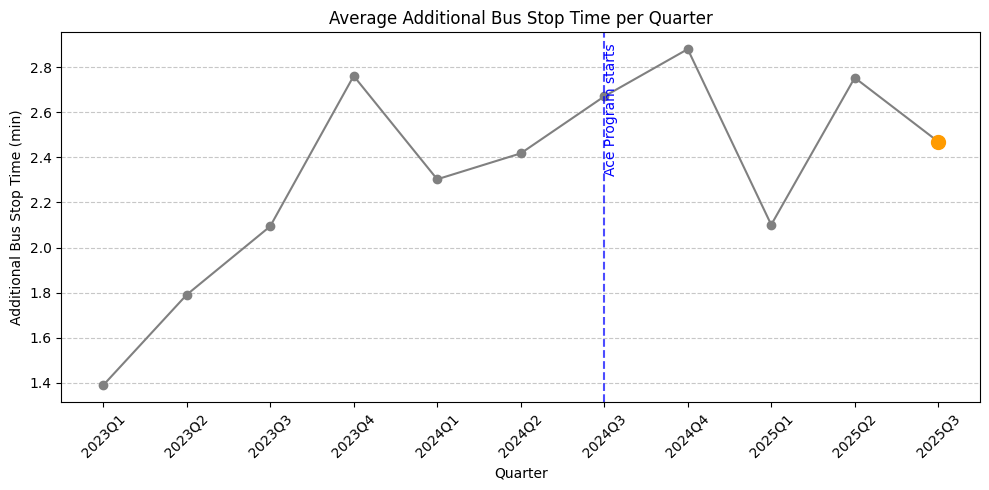

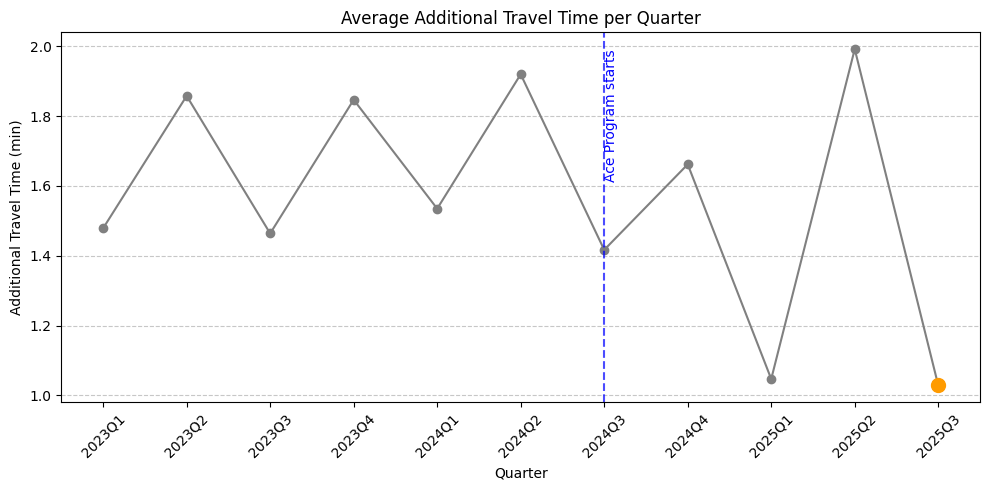

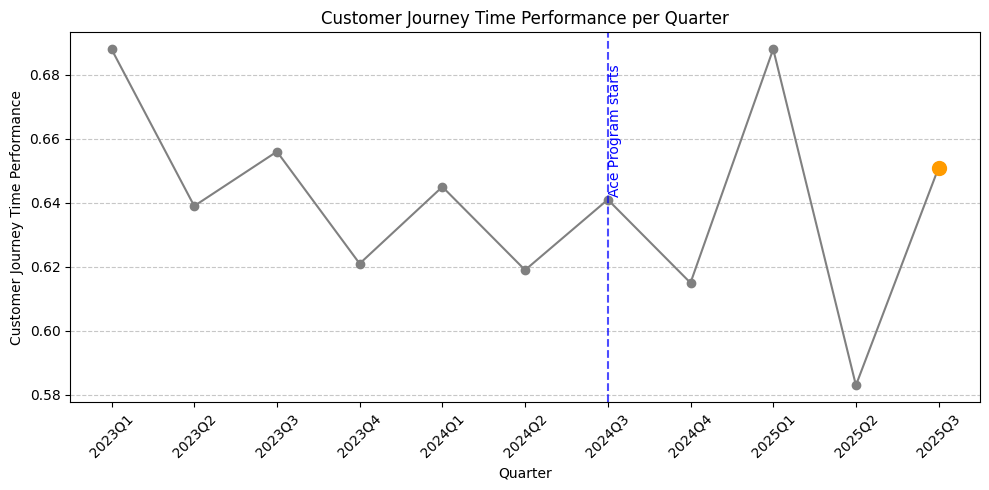

In [25]:
import matplotlib.pyplot as plt

# Convert quarter to string for plotting
additional_bus_stop_time_df["quarter_str"] = additional_bus_stop_time_df["quarter"].astype(str)
additional_travel_time_df["quarter_str"] = additional_travel_time_df["quarter"].astype(str)
customer_journey_time_performance_df["quarter_str"] = customer_journey_time_performance_df["quarter"].astype(str)

# 1. Additional Bus Stop Time
plt.figure(figsize=(10,5))
plt.plot(additional_bus_stop_time_df["quarter_str"], additional_bus_stop_time_df["additional_bus_stop_time"], color="gray", marker='o')
plt.plot(additional_bus_stop_time_df["quarter_str"].iloc[-1], additional_bus_stop_time_df["additional_bus_stop_time"].iloc[-1], marker='o', color="#FF9B00", markersize=10)
plt.axvline(x="2024Q3", color='blue', linestyle='--', alpha=0.7)
plt.text("2024Q3", plt.ylim()[1]-0.05, "Ace Program starts", rotation=90, verticalalignment='top', color='blue')
plt.xlabel("Quarter")
plt.ylabel("Additional Bus Stop Time (min)")
plt.title("Average Additional Bus Stop Time per Quarter")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# 2. Additional Travel Time
plt.figure(figsize=(10,5))
plt.plot(additional_travel_time_df["quarter_str"], additional_travel_time_df["additional_travel_time"], color="gray", marker='o')
plt.plot(additional_travel_time_df["quarter_str"].iloc[-1], additional_travel_time_df["additional_travel_time"].iloc[-1], marker='o', color="#FF9B00", markersize=10)
plt.axvline(x="2024Q3", color='blue', linestyle='--', alpha=0.7)
plt.text("2024Q3", plt.ylim()[1]-0.05, "Ace Program starts", rotation=90, verticalalignment='top', color='blue')
plt.xlabel("Quarter")
plt.ylabel("Additional Travel Time (min)")
plt.title("Average Additional Travel Time per Quarter")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# 3. Customer Journey Time Performance
plt.figure(figsize=(10,5))
plt.plot(customer_journey_time_performance_df["quarter_str"], customer_journey_time_performance_df["customer_journey_time_performance"], color="gray", marker='o')
plt.plot(customer_journey_time_performance_df["quarter_str"].iloc[-1], customer_journey_time_performance_df["customer_journey_time_performance"].iloc[-1], marker='o', color="#FF9B00", markersize=10)
plt.axvline(x="2024Q3", color='blue', linestyle='--', alpha=0.7)
plt.text("2024Q3", plt.ylim()[1]-0.01, "Ace Program starts", rotation=90, verticalalignment='top', color='blue')
plt.xlabel("Quarter")
plt.ylabel("Customer Journey Time Performance")
plt.title("Customer Journey Time Performance per Quarter")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()
